# WF of taste Profile dataset using Apache Spark MLlib

In [1]:
from __future__ import print_function, division

import sys, os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-ibm-1.8.0.3.10-1jpp.2.el7_2.x86_64/jre/"
from cluster_tools import conf, context_creator

In [2]:
spark_exec_script = context_creator.spark_executable('2.1.1', 'BT', num_exec=16, exec_mem='12g', exec_cores=8)
spark_exec_script

PYSPARK SHELL:  --executor-cores 8 --executor-memory 12g --deploy-mode client --num-executors 16 --master yarn --driver-memory 4g --driver-cores 1 pyspark-shell


'/home/hadoop/datashdp/shared/spark-2.1.1-bin-hadoop2.6/python/pyspark/shell.py'

In [3]:
execfile(spark_exec_script)

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.1.1
      /_/

Using Python version 2.7.12 (default, Sep 19 2016 21:05:09)
SparkSession available as 'spark'.


In [4]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse
import pandas as pd

In [5]:
DATA_ROOT = '/home/net1/appry001/data/expo-mf-data'

In [6]:
unique_uid = list()
with open(os.path.join(DATA_ROOT, 'unique_uid_sub_20.txt'), 'r') as f:
    for line in f:
        unique_uid.append(line.strip())
    
unique_sid = list()
with open(os.path.join(DATA_ROOT, 'unique_sid_sub_50.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

In [7]:
n_songs = len(unique_sid)
n_users = len(unique_uid)
n_songs, n_users

(22781, 211830)

In [8]:
HDFS = conf.bt_hdfs
HDFS

'hdfs://lhdppn01p35.staples.com:8020'

In [9]:
def load_csv(path):
    lines = []
    with open(path, 'rb') as fobj:
        headers = fobj.readline()
        print(headers)
        for line in fobj.readlines():
            lines.append(line.strip())
    return lines

In [10]:
train_lines = load_csv(os.path.join(DATA_ROOT, 'train.num.sub.20.50.csv'))

uid,sid,count



In [11]:
train_outp = os.path.join(HDFS, 'user/appry001/expo-mf-data/', 'train.num.sub.20.50')
train_outp

'hdfs://lhdppn01p35.staples.com:8020/user/appry001/expo-mf-data/train.num.sub.20.50'

In [13]:
sc.parallelize(train_lines).saveAsTextFile(train_outp)

In [14]:
test_lines = load_csv(os.path.join(DATA_ROOT, 'test.num.sub.20.50.csv'))

uid,sid,count



In [15]:
test_outp = os.path.join(HDFS, 'user/appry001/expo-mf-data/', 'test.num.sub.20.50')
test_outp

'hdfs://lhdppn01p35.staples.com:8020/user/appry001/expo-mf-data/test.num.sub.20.50'

In [16]:
sc.parallelize(test_lines).saveAsTextFile(test_outp)

## Load the data and train the model

In [60]:
train = sc.textFile(train_outp).map(lambda l: l.split(','))
train.take(3)

[[u'152137', u'378', u'1'],
 [u'152137', u'1142', u'1'],
 [u'152137', u'1622', u'2']]

In [61]:
test = sc.textFile(test_outp).map(lambda l: l.split(','))
test.take(3)

[[u'152137', u'1004', u'2'],
 [u'152137', u'4772', u'1'],
 [u'152137', u'12342', u'1']]

In [62]:
import numpy as np
from pyspark.mllib.recommendation import ALS, Rating, MatrixFactorizationModel

In [81]:
train.take(3)

[[u'152137', u'378', u'1'],
 [u'152137', u'1142', u'1'],
 [u'152137', u'1622', u'2']]

In [85]:
train_rating = train.map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2])))
test_rating = test.map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2])))

In [86]:
train_data = train_rating.map(lambda (u, i, r): (u, i))
test_data = test_rating.map(lambda (u, i, r): (u, i))

In [94]:
user_test = test_data.map(lambda (u, i): (u, [i])).reduceByKey(lambda x, y: x + y)

In [134]:
def recall_k(user_eval, k):
    user = user_eval[0]
    test_set = user_eval[1][0]
    pred_set = user_eval[1][1]
    pred_set = set(map(lambda x: x[1], pred_set[:k]))
    return np.sum([item in pred_set for item in test_set]) / min(k, len(test_set))
recall_k(example, 50)

0.33333333333333331

In [172]:
example

(33024,
 ([3015, 4908, 9389, 12581, 20463, 22203],
  (Rating(user=33024, product=767, rating=1.010425100767255),
   Rating(user=33024, product=16808, rating=0.9795957816718908),
   Rating(user=33024, product=5198, rating=0.9587349970638639),
   Rating(user=33024, product=854, rating=0.9498261300404074),
   Rating(user=33024, product=1458, rating=0.940641987097915),
   Rating(user=33024, product=3015, rating=0.6117592657086234),
   Rating(user=33024, product=19256, rating=0.5984055407532003),
   Rating(user=33024, product=1467, rating=0.5389381892829143),
   Rating(user=33024, product=6170, rating=0.5294722983425844),
   Rating(user=33024, product=18675, rating=0.5290264851484119),
   Rating(user=33024, product=3284, rating=0.49192175086306134),
   Rating(user=33024, product=5599, rating=0.4720803830453415),
   Rating(user=33024, product=6325, rating=0.4488525576389953),
   Rating(user=33024, product=19471, rating=0.41473535356704017),
   Rating(user=33024, product=17922, rating=0.40323

In [135]:
def train_eval_model(alpha, lambda_):
    rank = 100
    max_iter = 15
    model = ALS.trainImplicit(train_rating,
                              rank,
                              alpha=alpha,
                              lambda_=lambda_,
                              iterations=max_iter)
    user_recs = model.recommendProductsForUsers(100)    
    user_evaluation = user_test.join(user_recs)
    user_recall_50 = user_evaluation.map(lambda x: recall_k(x, 50)).mean()
    user_recall_20 = user_evaluation.map(lambda x: recall_k(x, 20)).mean()
    
    return {'recall50': user_recall_50,
            'recall20': user_recall_20}

In [129]:
def param_samp(low, high, num):
    loglower = np.log(low)
    logupper = np.log(high)
    logvals = np.random.uniform(loglower, logupper, num)
    return np.exp(logvals)
param_samp(0.01, 100, 5)

array([  0.03957641,   0.13627633,   0.60477297,  18.57727456,   0.11492544])

In [130]:
alphas = param_samp(0.01, 100, 5)
lambdas = param_samp(0.01, 10, 5)
params = zip(alphas, lambdas)

In [136]:
for alpha, lambda_ in params:
    tup = alpha, lambda_, train_eval_model(alpha, lambda_)
    data.append(tup)
    print(tup)

(17.825145142751957, 0.27104225706618851, {'recall50': 0.2284756767357165, 'recall20': 0.12837532313902669})
(25.422385721221822, 0.24212374137682507, {'recall50': 0.22812094425233442, 'recall20': 0.1272428605470298})
(0.46495982438481859, 6.8501848320498828, {'recall50': 0.0020546340954205821, 'recall20': 0.00044770480659315489})
(4.978924437131738, 2.7261454684745985, {'recall50': 0.1862848227642612, 'recall20': 0.10499244200869294})
(1.3176000888200261, 4.8224979959935528, {'recall50': 0.020219911184464992, 'recall20': 0.012085660276751514})


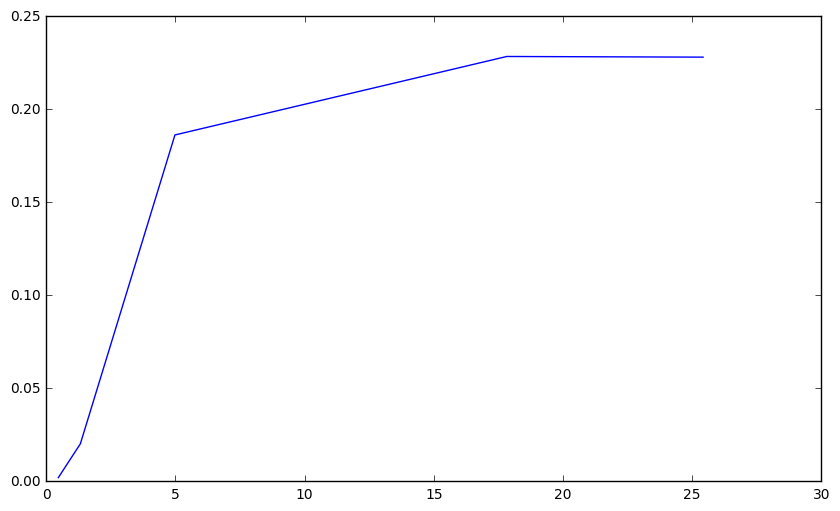

In [150]:
x_alp, y_rec50 = zip(*sorted(map(lambda (a, l, d): (a, d['recall50']), data), key=lambda x: x[0]))
x_alp, y_rec20 = zip(*sorted(map(lambda (a, l, d): (a, d['recall20']), data), key=lambda x: x[0]))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_alp, y_rec50)
ax.plot(x_alp, y_rec20)

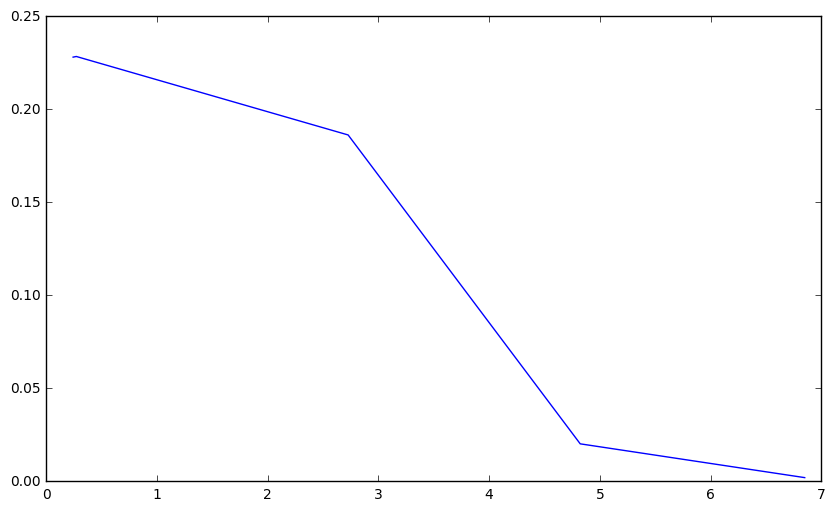

In [152]:
x_lam, y_rec50 = zip(*sorted(map(lambda (a, l, d): (l, d['recall50']), data), key=lambda x: x[0]))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_lam, y_rec50)

In [153]:
# more params
alphas = param_samp(1, 1000, 5)
lambdas = param_samp(0.01, 1, 5)
new_params = zip(alphas, lambdas)


In [ ]:

for alpha, lambda_ in new_params:
    tup = alpha, lambda_, train_eval_model(alpha, lambda_)
    data.append(tup)
    print(tup)

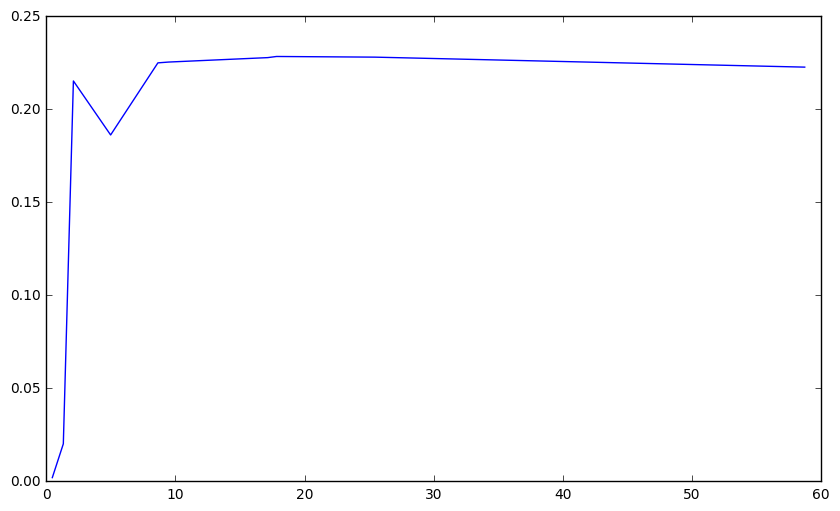

In [155]:
x_alp, y_rec50 = zip(*sorted(map(lambda (a, l, d): (a, d['recall50']), data), key=lambda x: x[0]))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_alp, y_rec50)

In [157]:
x_alp

(0.46495982438481859,
 1.3176000888200261,
 2.0978396422694803,
 4.978924437131738,
 8.6400201220477548,
 9.4787689703857421,
 17.137948393273099,
 17.825145142751957,
 25.422385721221822,
 58.716915971916201)

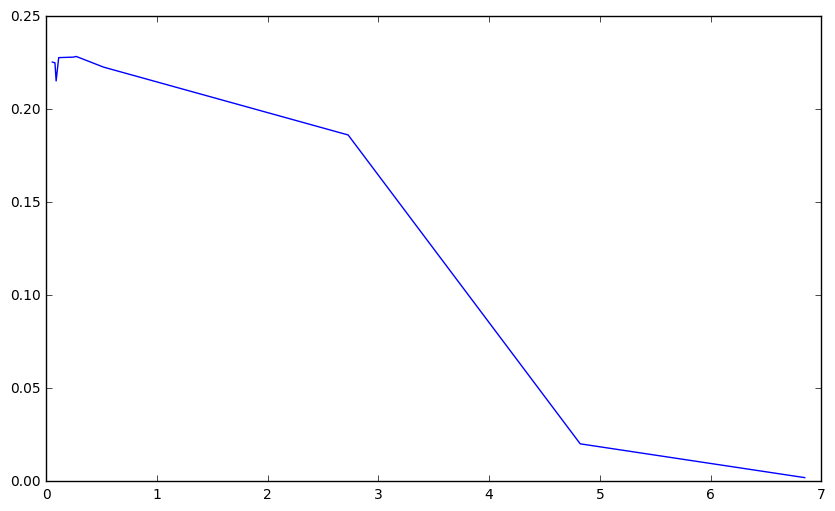

In [156]:
x_lam, y_rec50 = zip(*sorted(map(lambda (a, l, d): (l, d['recall50']), data), key=lambda x: x[0]))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_lam, y_rec50)

In [158]:
alphas = param_samp(0.1, 20, 5)
lambdas = param_samp(0.001, 0.1, 5)
new_params = zip(alphas, lambdas)

In [159]:
for alpha, lambda_ in new_params:
    tup = alpha, lambda_, train_eval_model(alpha, lambda_)
    data.append(tup)
    print(tup)

(7.6589112763894978, 0.023491205994342731, {'recall50': 0.2239953433857263, 'recall20': 0.12730612647673686})
(1.1277785021032187, 0.034940589681888602, {'recall50': 0.20893012324255025, 'recall20': 0.11911845562054402})
(0.71838648118929327, 0.0042801846436835026, {'recall50': 0.20316568658653458, 'recall20': 0.11478374970387588})
(0.95509178534408645, 0.0041900757066951943, {'recall50': 0.20581956750691457, 'recall20': 0.11670860012843023})
(5.6119225066467155, 0.004614110824396998, {'recall50': 0.22152404720230032, 'recall20': 0.12604714201157557})


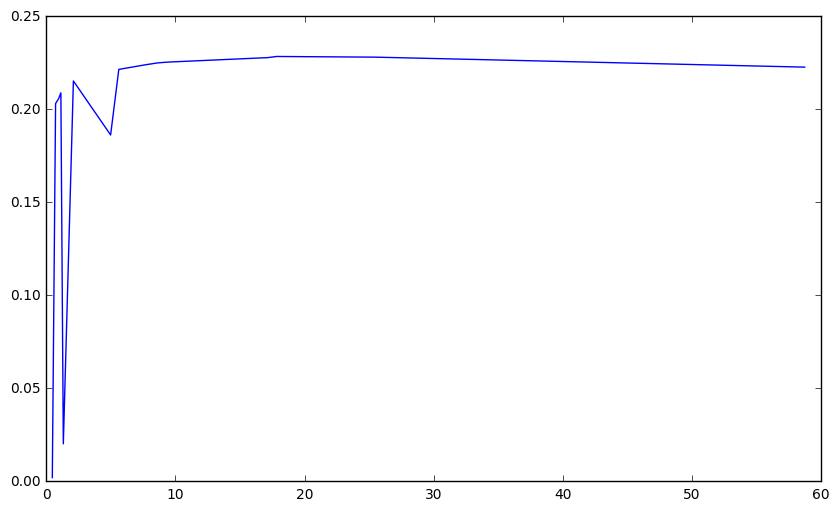

In [160]:
x_alp, y_rec50 = zip(*sorted(map(lambda (a, l, d): (a, d['recall50']), data), key=lambda x: x[0]))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_alp, y_rec50)

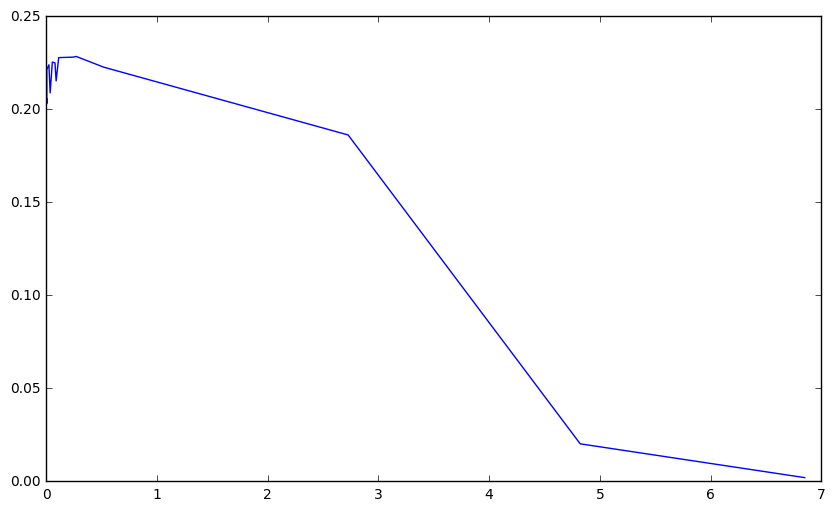

In [161]:
x_lam, y_rec50 = zip(*sorted(map(lambda (a, l, d): (l, d['recall50']), data), key=lambda x: x[0]))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_lam, y_rec50)

In [168]:
alphas = param_samp(50, 200, 2)
lambdas = param_samp(0.001, 0.01, 2)
new_params = zip(alphas, lambdas)

In [169]:
for alpha, lambda_ in new_params:
    tup = alpha, lambda_, train_eval_model(alpha, lambda_)
    data.append(tup)
    print(tup)

(121.63615436781294, 0.0076229807925249395, {'recall50': 0.2035539289386884, 'recall20': 0.10688947155439578})
(195.50669472382492, 0.0017811456521684191, {'recall50': 0.1895139763108547, 'recall20': 0.097036605862472786})


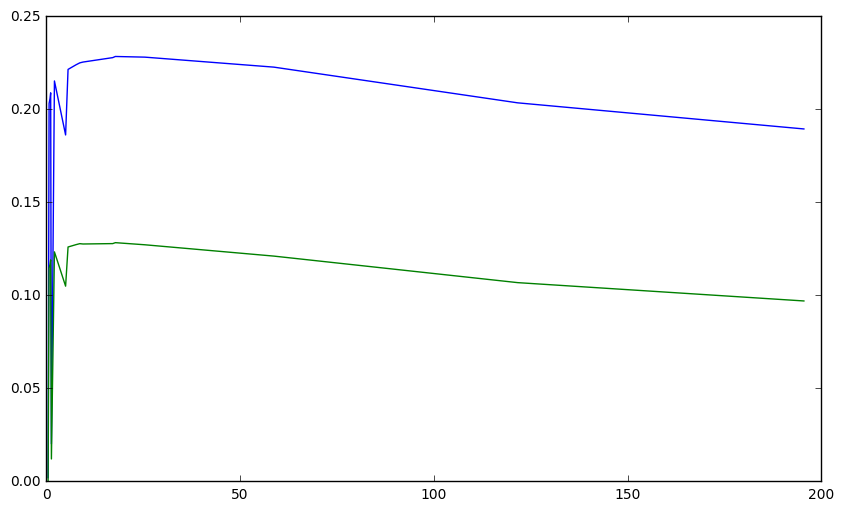

In [171]:
x_alp, y_rec50 = zip(*sorted(map(lambda (a, l, d): (a, d['recall50']), data), key=lambda x: x[0]))
x_alp, y_rec20 = zip(*sorted(map(lambda (a, l, d): (a, d['recall20']), data), key=lambda x: x[0]))
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x_alp, y_rec50)
ax.plot(x_alp, y_rec20)

In [173]:
sc.stop()